In [1]:
import pandas as pd
df=pd.read_parquet('2_df.parquet')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2288 entries, 0 to 2287
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   node        2288 non-null   object 
 1   vector      2288 non-null   object 
 2   dimensions  2288 non-null   object 
 3   x           2288 non-null   float32
 4   y           2288 non-null   float32
dtypes: float32(2), object(3)
memory usage: 89.4+ KB


,node,vector,dimensions,x,y
0,is composed of,"[-0.1965474, -0.22043273, 0.15672809, 0.294845...",128,-3.561454,2.153782
1,consists of,"[0.13023283, -0.12645757, 0.09158786, 0.552914...",128,-3.393269,2.257844
2,made up of,"[-0.23936953, -0.25913587, -0.076853864, 0.203...",128,-3.526391,1.445802
3,has terrain,"[0.10827221, -0.111704014, 0.31453288, 0.40511...",128,-2.399560,3.087808
4,features,"[0.2875019, -0.14414185, 0.40290186, 0.4336873...",128,-2.250950,3.137842


wizmap silverman
```python
d = 2
n =1E5
bw = (n * (d + 2) / 4.0) ** (-1.0 / (d + 4))
bw
```

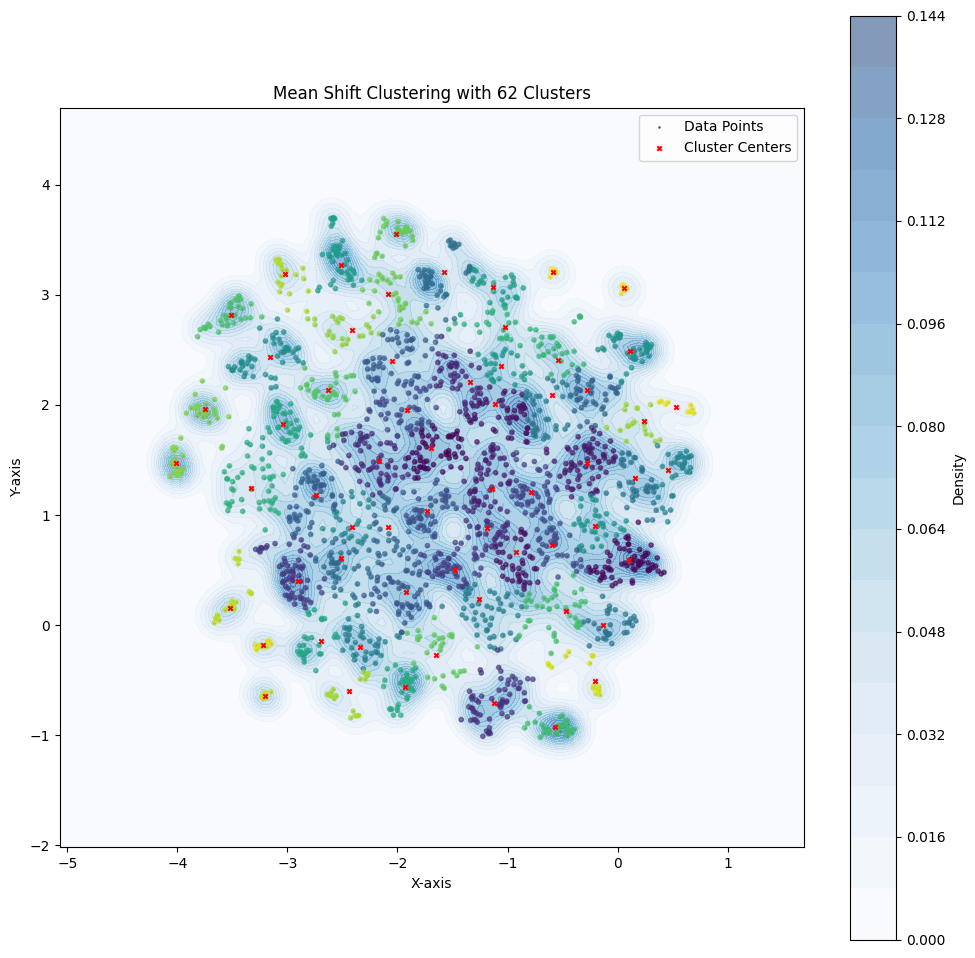

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.cluster import MeanShift, estimate_bandwidth

bw=0.1
# Extracting the x and y columns for KDE
x = df['x'].values
y = df['y'].values

# Using smaller bandwidth for better visualization
data_points = np.vstack([x, y])
smaller_bandwidth_kde = gaussian_kde(data_points, bw_method=bw)

# Creating a grid for KDE
xmin, xmax = x.min() - 1, x.max() + 1
ymin, ymax = y.min() - 1, y.max() + 1
x_grid, y_grid = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Evaluating the KDE
smaller_kde_values = smaller_bandwidth_kde(grid_points).reshape(x_grid.shape)

# Plotting the data points and adjusted KDE
plt.figure(figsize=(12, 12))
plt.scatter(x, y, s=1, label='Data Points', alpha=0.5, color='black')
plt.contourf(x_grid, y_grid, smaller_kde_values, levels=20, cmap='Blues', alpha=0.5)
plt.colorbar(label='Density', orientation='vertical')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data Points and KDE (Adjusted Bandwidth with Blue Density)')
plt.legend()
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
# plt.gca().set_facecolor('white')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()
# plt.show()

data = data_points.T
# Step 4: Run Mean Shift Clustering
# bandwidth = estimate_bandwidth(data, quantile=0.2)
ms = MeanShift(bandwidth=bw*3.0, bin_seeding=True)
ms.fit(data)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(labels))

# Step 5: Visualize Mean Shift Clustering Results
# plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=10, label="Cluster Centers")
plt.title(f"Mean Shift Clustering with {n_clusters} Clusters")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid()
plt.show()


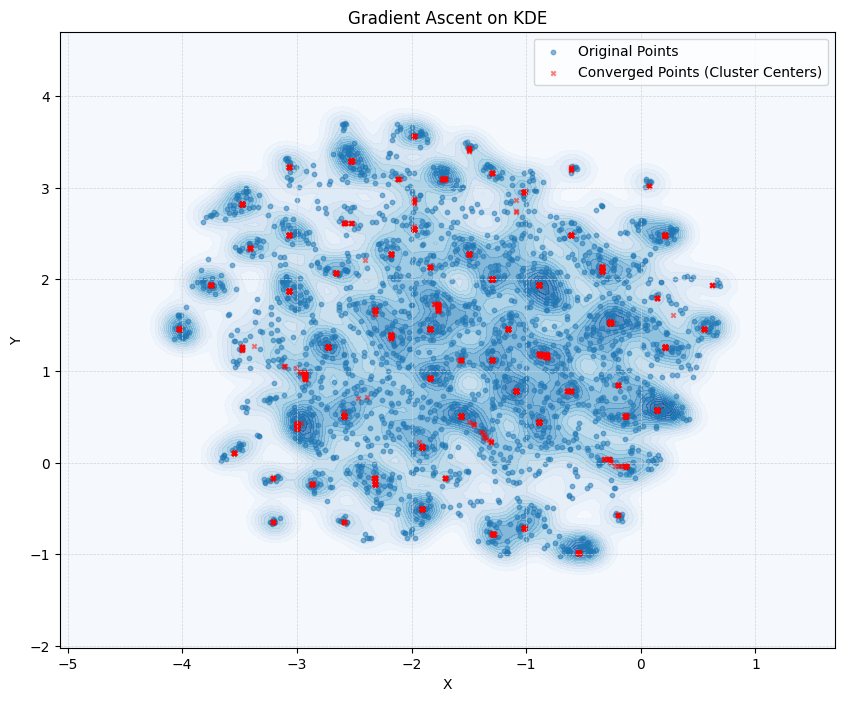

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_gradient_magnitude

# Grid settings
x_grid, y_grid = np.meshgrid(
    np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100)
)

# Evaluate KDE
kde_values = smaller_bandwidth_kde(grid_points).reshape(x_grid.shape)

# Compute gradients of the KDE
kde_gradient_x = np.gradient(kde_values, axis=1)
kde_gradient_y = np.gradient(kde_values, axis=0)

# Gradient ascent for each point
def gradient_ascent(x0, y0, max_iter=2000, lr=0.1, tol=1e-5):
    x, y = x0, y0
    for _ in range(max_iter):
        # Map (x, y) to grid indices
        xi = int((x - xmin) / (xmax - xmin) * (kde_values.shape[1] - 1))
        yi = int((y - ymin) / (ymax - ymin) * (kde_values.shape[0] - 1))
        
        # Boundary check
        if xi < 0 or xi >= kde_values.shape[1] or yi < 0 or yi >= kde_values.shape[0]:
            break
        
        # Gradient ascent step
        grad_x = kde_gradient_x[yi, xi]
        grad_y = kde_gradient_y[yi, xi]
        x_new = x + lr * grad_x
        y_new = y + lr * grad_y
        
        # Check for convergence
        if np.sqrt((x_new - x)**2 + (y_new - y)**2) < tol:
            break
        x, y = x_new, y_new
    
    return x, y

# Apply gradient ascent to each data point
# converged_points = np.array([gradient_ascent(xi, yi) for xi, yi in zip(x, y)])
converged_points = np.array([gradient_ascent(xi, yi) for xi, yi in data])


# Plot results
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, kde_values, levels=20, cmap="Blues", alpha=0.7)
plt.scatter(x, y, s=10, label="Original Points", alpha=0.5)
plt.scatter(
    converged_points[:, 0]-0.5*bw,
    converged_points[:, 1]-0.5*bw,
    marker='x', s=10,
    color="red",
    label="Converged Points (Cluster Centers)",
    alpha=0.5,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gradient Ascent on KDE")
plt.legend()
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.show()


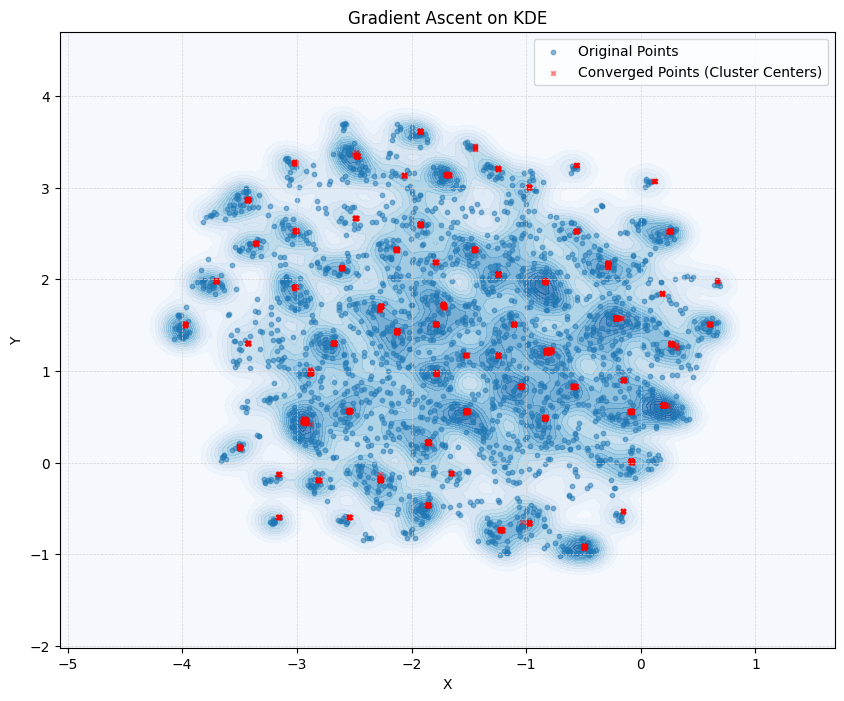

In [4]:
def adam_optimizer(x0, y0, max_iter=1000, lr=0.01, tol=1e-4):
    x, y = x0, y0
    m_x, m_y = 0, 0  # First moments
    v_x, v_y = 0, 0  # Second moments
    beta1, beta2 = 0.9, 0.999
    epsilon = 1e-8

    for t in range(1, max_iter + 1):
        xi = int((x - xmin) / (xmax - xmin) * (kde_values.shape[1] - 1))
        yi = int((y - ymin) / (ymax - ymin) * (kde_values.shape[0] - 1))

        if xi < 0 or xi >= kde_values.shape[1] or yi < 0 or yi >= kde_values.shape[0]:
            break

        grad_x = kde_gradient_x[yi, xi]
        grad_y = kde_gradient_y[yi, xi]

        m_x = beta1 * m_x + (1 - beta1) * grad_x
        m_y = beta1 * m_y + (1 - beta1) * grad_y

        v_x = beta2 * v_x + (1 - beta2) * grad_x**2
        v_y = beta2 * v_y + (1 - beta2) * grad_y**2

        m_x_hat = m_x / (1 - beta1**t)
        m_y_hat = m_y / (1 - beta1**t)
        v_x_hat = v_x / (1 - beta2**t)
        v_y_hat = v_y / (1 - beta2**t)

        x_new = x + lr * m_x_hat / (np.sqrt(v_x_hat) + epsilon)
        y_new = y + lr * m_y_hat / (np.sqrt(v_y_hat) + epsilon)

        if np.sqrt((x_new - x)**2 + (y_new - y)**2) < tol:
            break

        x, y = x_new, y_new

    return x, y

# Apply Adam optimization
converged_points = np.array([adam_optimizer(xi, yi) for xi, yi in zip(x, y)])

# Plot results
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, kde_values, levels=20, cmap="Blues", alpha=0.7)
plt.scatter(x, y, s=10, label="Original Points", alpha=0.5)
plt.scatter(
    converged_points[:, 0],
    converged_points[:, 1],
    marker='x', s=10,
    color="red",
    label="Converged Points (Cluster Centers)",
    alpha=0.5,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gradient Ascent on KDE")
plt.legend()
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.show()

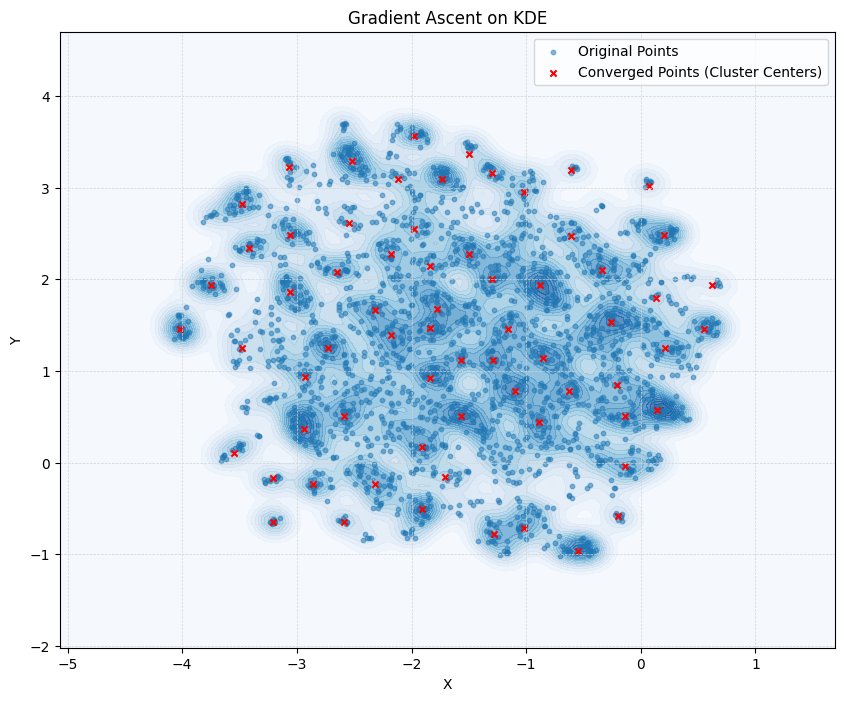

In [5]:
# Post-process to merge nearby clusters
def post_process_clusters(points, threshold=0.1):
    unique_points = []
    for point in points:
        if not any(np.linalg.norm(point - up) < threshold for up in unique_points):
            unique_points.append(list(point))
    # return np.array(unique_points)
    return np.array(unique_points)

cluster_centers = post_process_clusters(converged_points)

# Plot results
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, kde_values, levels=20, cmap="Blues", alpha=0.7)
plt.scatter(x, y, s=10, label="Original Points", alpha=0.5)
plt.scatter(
    cluster_centers[:, 0]-0.5*bw,
    cluster_centers[:, 1]-0.5*bw,
    marker='x', s=20,
    color="red",
    label="Converged Points (Cluster Centers)",
    alpha=1.0,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gradient Ascent on KDE")
plt.legend()
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.show()

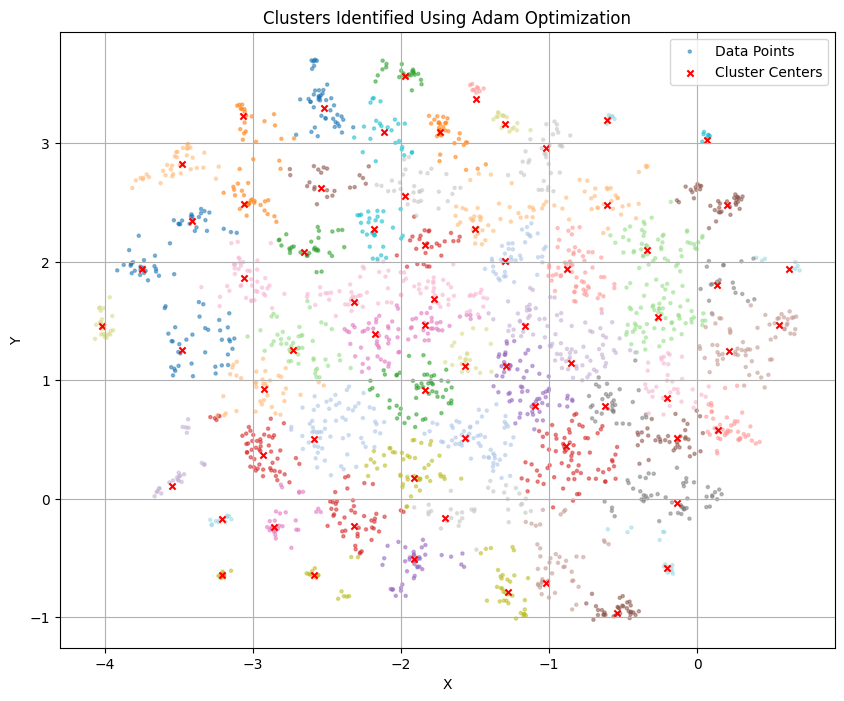

In [8]:
# Assign data points to clusters
def assign_clusters(points, centers):
    return np.array([np.argmin(np.linalg.norm(centers - p, axis=1)) for p in points])

assignments = assign_clusters(np.vstack([x, y]).T, cluster_centers)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=assignments, cmap="tab20", s=5, label="Data Points", alpha=0.5)
plt.scatter(cluster_centers[:, 0]-0.5*bw, cluster_centers[:, 1]-0.5*bw, s=20, c='red', label="Cluster Centers", marker='x')
plt.title("Clusters Identified Using Adam Optimization")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()


In [7]:
assignments

array([ 0,  1,  2, ..., 52, 13, 13])